# Assignment 6

### <span style="color:chocolate"> Submission requirements </span>

Your work will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:
    
* Comment your code;
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own;
* Try and minimize the use of the global namespace (meaning, keep things inside functions).

``Objectives``

* This assignment connects all the pieces involved in training feed-forward fully connected neural networks (FFNN); 

* You will run a full set of experiments to explore different hyperparameters and hidden layer sizes for two datasets, and then document your findings.

``Data``
* Digits MNIST
* Fashion MNIST

### Import libraries

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

from keras.datasets import fashion_mnist
from keras.datasets import mnist

import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

2024-10-13 22:12:01.968308: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-13 22:12:02.093980: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-13 22:12:02.129213: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-13 22:12:02.361987: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-13 22:12:04.269840: W tensorflow/compiler/tf2

---
### Step 1: Data ingestion

In [2]:
# Load the Fashion MNIST dataset.
(X_train_fashion, Y_train_fashion), (X_test_fashion, Y_test_fashion) = fashion_mnist.load_data()

# Load the Digits MNIST dataset.
(X_train_digits, Y_train_digits), (X_test_digits, Y_test_digits) = mnist.load_data()

---
### Step 2: Data preprocessing

``Fashion MNIST``

In [4]:
# Normalize
X_train_fashion = X_train_fashion / 255.
X_test_fashion = X_test_fashion / 255.

# Flatten Y_train and Y_test, so they become vectors of label values.
Y_train_fashion = Y_train_fashion.flatten()
Y_test_fashion = Y_test_fashion.flatten()

label_names = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
               'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

# Apply random shufflying to training examples.
np.random.seed(0)
indices = np.arange(X_train_fashion.shape[0])
shuffled_indices = np.random.permutation(indices)
X_train_fashion = X_train_fashion[shuffled_indices]
Y_train_fashion = Y_train_fashion[shuffled_indices]

``Digits MNIST``

In [5]:
# Normalize
X_train_digits = X_train_digits / 255.
X_test_digits = X_test_digits / 255.

# Flatten Y_train and Y_test, so they become vectors of label values.
Y_train_digits = Y_train_digits.flatten()
Y_test_digits = Y_test_digits.flatten()

# Apply random shufflying to training examples.
np.random.seed(0)
indices = np.arange(X_train_digits.shape[0])
shuffled_indices = np.random.permutation(indices)
X_train_digits = X_train_digits[shuffled_indices]
Y_train_digits = Y_train_digits[shuffled_indices]

---
### Step 3: Exploratory data analysis (EDA)

### <span style="color:chocolate">Exercise 1:</span> Getting to know your data (5 points)

Complete the following task:

1. Show the first training example in X_train_fashion;
2. Show the first training example in X_train_digits;
3. Display the first 5 images in X_train_digits for each class in Y_train_digits, arranged in a 10x5 grid. 

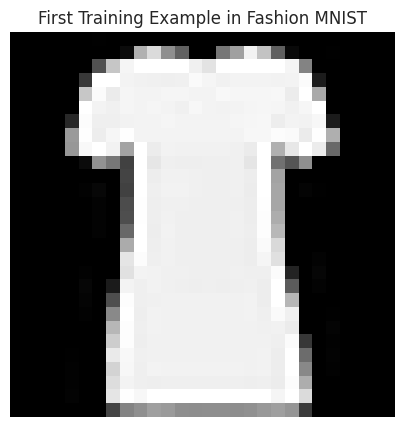

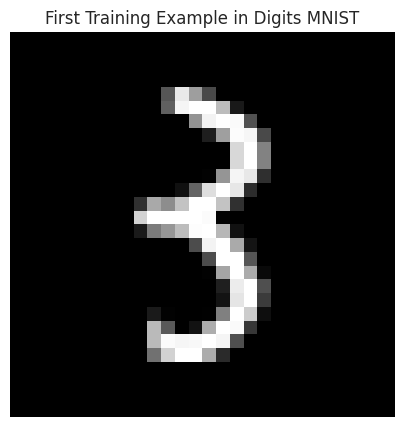

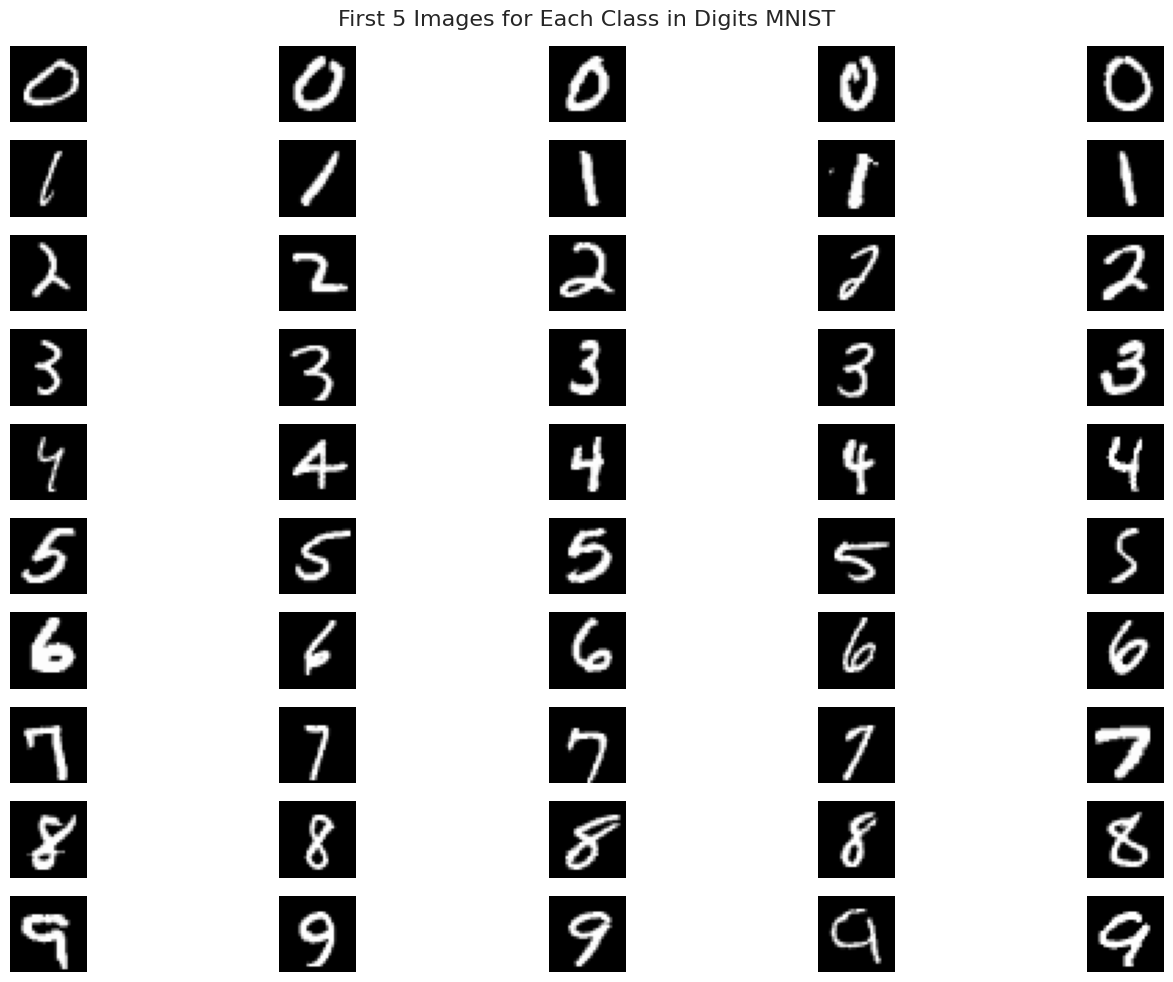

In [6]:
# YOUR CODE HERE

#show first training example in Fashion MNIST
plt.figure(figsize = (5,5))
plt.title("First Training Example in Fashion MNIST")
plt.imshow(X_train_fashion[0], cmap="gray")
plt.axis("off")
plt.show()

#show first training example in Digits MNIST
plt.figure(figsize = (5,5))
plt.title("First Training Example in Digits MNIST")
plt.imshow(X_train_digits[0], cmap="gray")
plt.axis("off")
plt.show()

#display first 5 images in X_train digits for each class in Y train digits
classes = np.unique(Y_train_digits)
num_classes = len(classes)
images_per_class = 5

plt.figure(figsize= (15,10))

for i, class_label in enumerate(classes):
    #get the first 5 images of the current class
    classes_indices = np.where(Y_train_digits == class_label)[0][:images_per_class]
    for j, idx in enumerate(classes_indices):
        plt.subplot(num_classes, images_per_class, i * images_per_class + j + 1)
        plt.imshow(X_train_digits[idx], cmap = "gray")
        plt.axis("off")
        if j == 0:
            plt.ylabel(f"class {class_label}", fontsize = 12)

plt.suptitle("First 5 Images for Each Class in Digits MNIST", fontsize = 16)
plt.tight_layout()
plt.show()

### Step 4: Modeling

### <span style="color:chocolate">Exercise 2:</span> Define model (20 points)

1. Fill in the <span style="color:chocolate">build_model()</span> function below, including all the arguments listed in the function definition. Note: the activation function parameter is only for the the hidden layers; use the appropriate final classification function for the final layer.

In [7]:
def build_model(n_classes,
                hidden_layer_sizes=[],
                activation ='relu',
                optimizer='SGD',
                learning_rate=0.01,
                metric='accuracy'):
    """Build a multi-class logistic regression model using Keras.

    Args:
    n_classes: Number of output classes in the dataset.
    hidden_layer_sizes: A list with the number of units in each hidden layer.
    activation: The activation function to use for the hidden layers.
    optimizer: The optimizer to use (SGD, Adam).
    learning_rate: The desired learning rate for the optimizer.
    metric: The desired metric.

    Returns:
    model: A tf.keras model (graph).
    """
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    # YOUR CODE HERE
    model = tf.keras.Sequential()

    #flatten the input layer to 784
    model.add(tf.keras.layers.Flatten(input_shape = (28, 28)))

    #Adding hidden layers
    for size in hidden_layer_sizes:
        model.add(tf.keras.layers.Dense(units = size, activation = activation))
    
    #using softmax activation for multiclass classfication in output layer
    model.add(tf.keras.layers.Dense(units = n_classes, activation = "softmax"))

    #Selecting optimizer
    if optimizer == "SGD":
        opt = tf.keras.optimizers.SGD(learning_rate = learning_rate)
    elif optimizer == "Adam":
        opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    else:
        raise ValueError("Unsupported Optimizer: %s" % optimizer)
    
    #compiling the model
    model.compile(optimizer = opt, loss = "sparse_categorical_crossentropy", metrics = [metric])


    return model  

---
### Step 5: Experiments

You can now run a suite of experiments to see how the hyperparameters and layer sizes effect model performance. 

The <span style="color:chocolate">train_and_evaluate()</span> function below can be used to run experiments and retrieve results.

/home/vanel/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training the digits model with [] hidden layers, tanh activation, Adam optimizer...


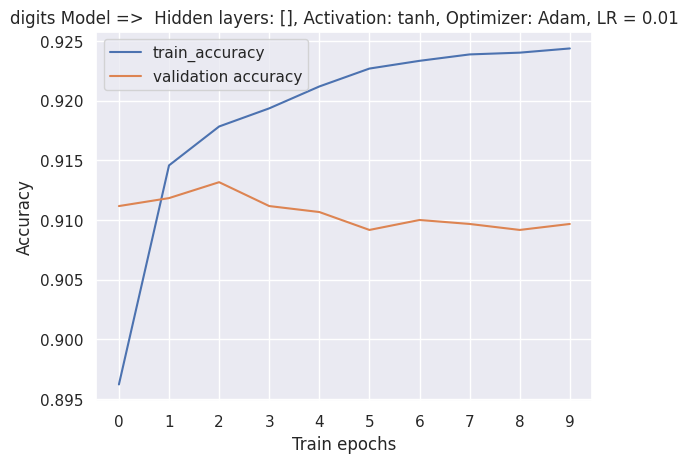

Training accuracy: 0.9244
Validation accuracy: 0.9097


In [8]:
def train_and_evaluate(data='digits',
                       hidden_layer_sizes=[],
                       activation='tanh',
                       optimizer='Adam',
                       learning_rate=0.01,
                       metric='accuracy',
                       num_epochs=10):

  # Build the model.
    model = build_model(n_classes=10,
                      hidden_layer_sizes=hidden_layer_sizes,
                      activation=activation,
                      optimizer=optimizer,
                      metric=metric,
                      learning_rate=learning_rate)

  # Select the dataset.
    if data == 'digits':
        X_train = X_train_digits
        X_test = X_test_digits
        Y_train = Y_train_digits
        Y_test = Y_test_digits
    
    elif data == 'fashion':
        X_train = X_train_fashion
        X_test = X_test_fashion
        Y_train = Y_train_fashion
        Y_test = Y_test_fashion
    else:
        raise 'Unsupported dataset: %s' %data

  # Train the model.
    print(f'Training the {data} model with {hidden_layer_sizes} hidden layers, {activation} activation, {optimizer} optimizer...')
    
    history = model.fit(
        x=X_train,
        y=Y_train,
        epochs=num_epochs,
        batch_size=64,
        validation_split=0.1,
        verbose=0)

    # Retrieve the training metrics (after each train epoch) and the final validation
    # accuracy.
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    #plotting training and validation accuracy
    plt.plot(train_accuracy, label='train_accuracy')
    plt.plot(val_accuracy, label='validation accuracy')
    plt.title(f'{data} Model =>  Hidden layers: {hidden_layer_sizes}, Activation: {activation}, Optimizer: {optimizer}, LR = {learning_rate}')
    plt.xticks(range(num_epochs))
    plt.xlabel('Train epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    print('Training accuracy: %1.4f' %train_accuracy[-1])
    print('Validation accuracy: %1.4f' %val_accuracy[-1])
    
    return model, history


# run the function
model = train_and_evaluate()

### <span style="color:chocolate">Exercise 3:</span> Ablation study (50 points)

1. Conduct experiments and record the training and validation set accuracy results in the table below. You may extend the table for additional experiments as needed.
2. Report the hyperparameter values for your preferred architecture configuration.
3. Run the model once more using your preferred hyperparameter configuration.

Data | Hidden sizes | Activation| Optimizer | Learning rate | #Parameters | Training accuracy| Validation accuracy
-|-|-|-|-|-|-|-
 digits | [] | tanh | SGD |0.01| 7850 | |
 digits | [] | relu | SGD |0.01| 7850 | |
 digits | [] | relu | Adam |0.01| 7850 | |
 digits | [128] | relu | Adam |0.01| 101770 | |
 digits | [256, 128] | relu | Adam |0.01| 235146 | |
-|-|-|-|-|-|-|-
 fashion | [] | tanh | SGD |0.01| 7850 | |
 fashion | [] | relu | SGD |0.01| 7850 | |
 fashion | [] | relu | Adam |0.01| 7850 | |
 fashion | [128] | relu | Adam |0.01| 101770 | |
 fashion | [256, 128] | relu | Adam |0.01| 235146 | |

Training the digits model with [] hidden layers, tanh activation, SGD optimizer...


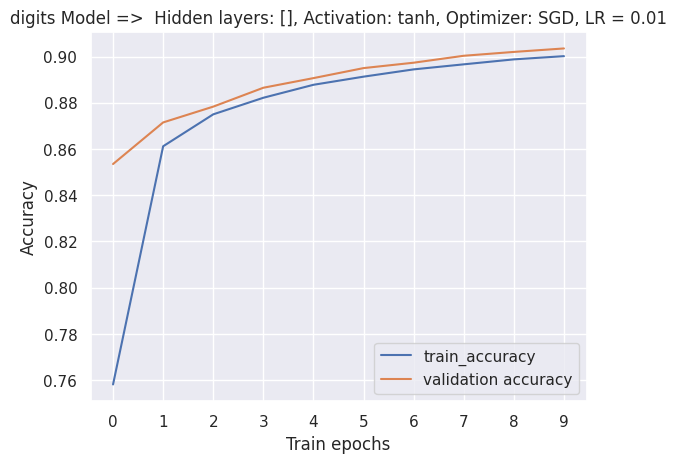

Training accuracy: 0.9002
Validation accuracy: 0.9035
Training the digits model with [] hidden layers, relu activation, SGD optimizer...


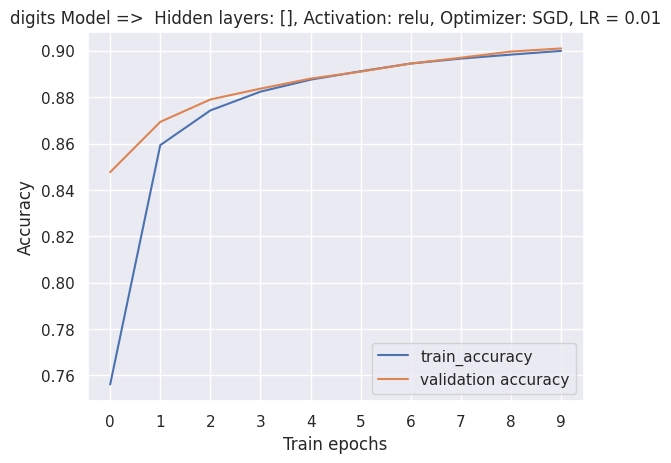

Training accuracy: 0.8999
Validation accuracy: 0.9010
Training the digits model with [] hidden layers, relu activation, Adam optimizer...


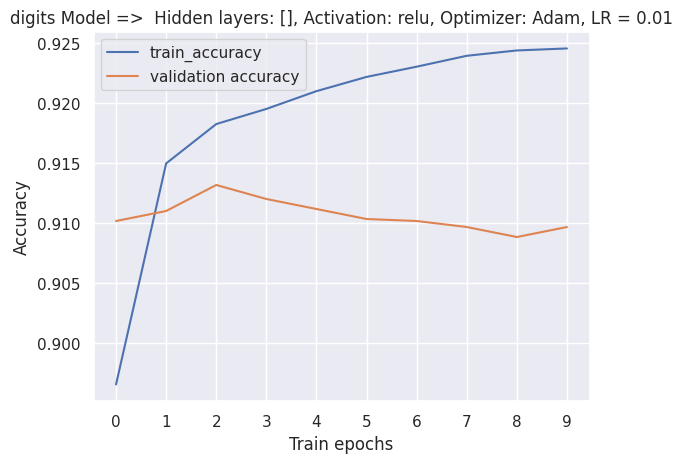

Training accuracy: 0.9245
Validation accuracy: 0.9097
Training the digits model with [128] hidden layers, relu activation, Adam optimizer...


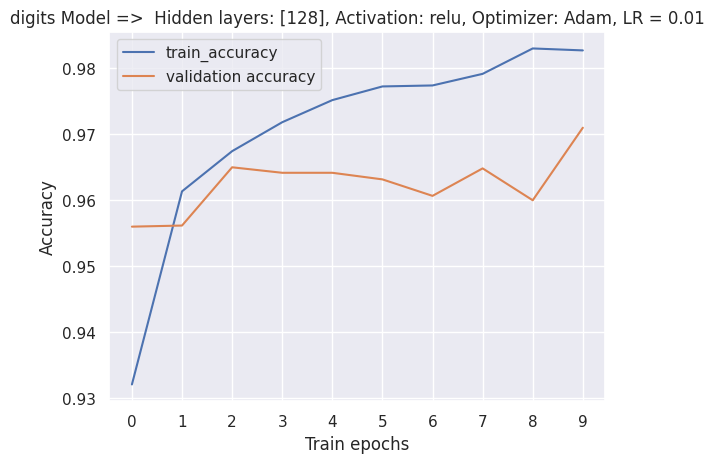

Training accuracy: 0.9827
Validation accuracy: 0.9710
Training the digits model with [256, 128] hidden layers, relu activation, Adam optimizer...


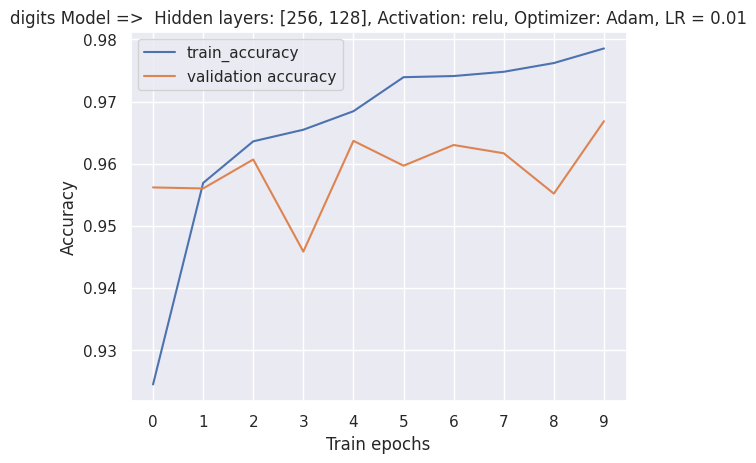

Training accuracy: 0.9786
Validation accuracy: 0.9668
Training the fashion model with [] hidden layers, tanh activation, SGD optimizer...


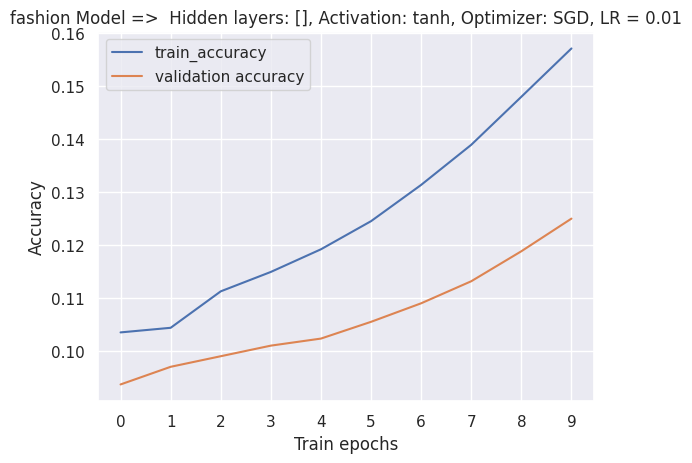

Training accuracy: 0.1571
Validation accuracy: 0.1250
Training the fashion model with [] hidden layers, relu activation, SGD optimizer...


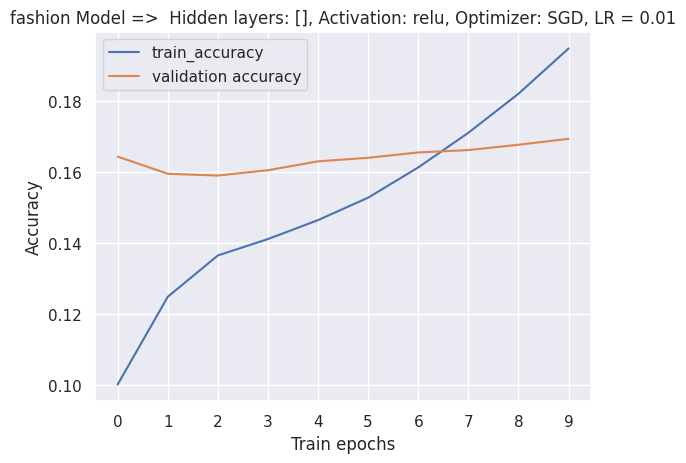

Training accuracy: 0.1948
Validation accuracy: 0.1693
Training the fashion model with [] hidden layers, relu activation, Adam optimizer...


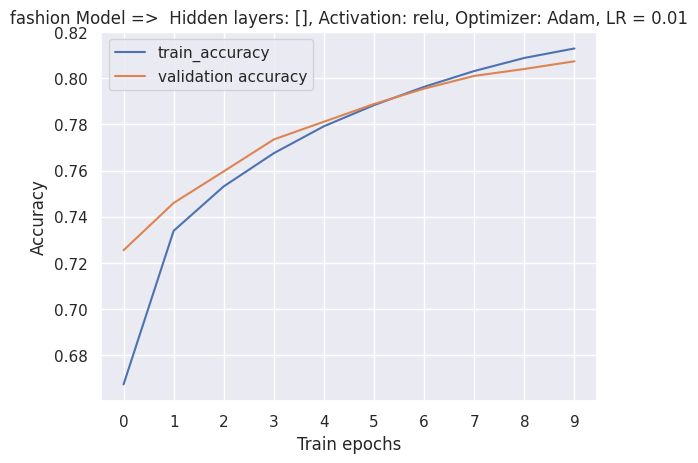

Training accuracy: 0.8129
Validation accuracy: 0.8073
Training the fashion model with [128] hidden layers, relu activation, Adam optimizer...


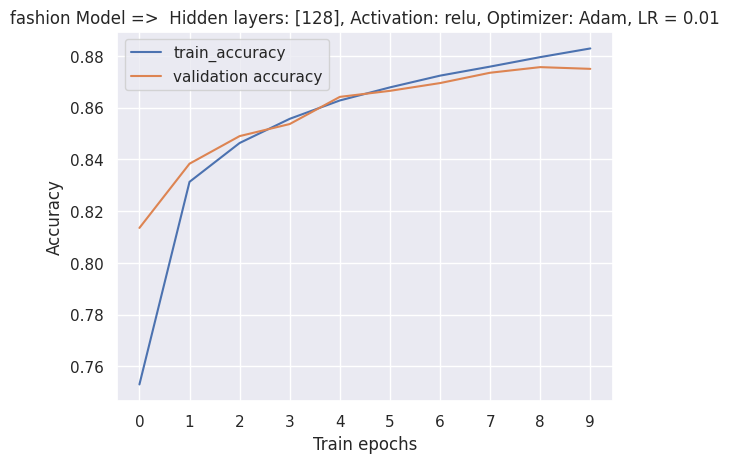

Training accuracy: 0.8829
Validation accuracy: 0.8750
Training the fashion model with [256, 128] hidden layers, relu activation, Adam optimizer...


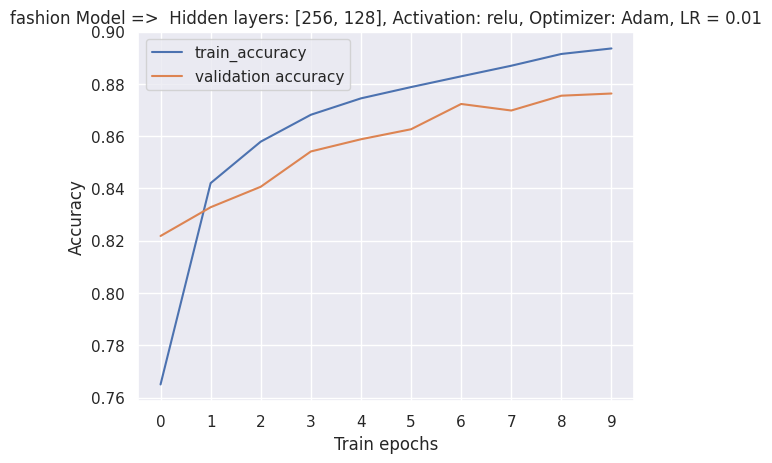

Training accuracy: 0.8936
Validation accuracy: 0.8763


In [10]:
# YOUR CODE HERE

# Running experiments and storing results
best_digits_experiment = None
best_fashion_experiment = None
best_digits_val_acc = 0
best_fashion_val_acc = 0

# List of hyperparameters to experiment with
experiments = [
    {'data': 'digits', 'hidden_layer_sizes': [], 'activation': 'tanh', 'optimizer': 'SGD', 'learning_rate': 0.01},
    {'data': 'digits', 'hidden_layer_sizes': [], 'activation': 'relu', 'optimizer': 'SGD', 'learning_rate': 0.01},
    {'data': 'digits', 'hidden_layer_sizes': [], 'activation': 'relu', 'optimizer': 'Adam', 'learning_rate': 0.01},
    {'data': 'digits', 'hidden_layer_sizes': [128], 'activation': 'relu', 'optimizer': 'Adam', 'learning_rate': 0.01},
    {'data': 'digits', 'hidden_layer_sizes': [256, 128], 'activation': 'relu', 'optimizer': 'Adam', 'learning_rate': 0.01},
    {'data': 'fashion', 'hidden_layer_sizes': [], 'activation': 'tanh', 'optimizer': 'SGD', 'learning_rate': 0.01},
    {'data': 'fashion', 'hidden_layer_sizes': [], 'activation': 'relu', 'optimizer': 'SGD', 'learning_rate': 0.01},
    {'data': 'fashion', 'hidden_layer_sizes': [], 'activation': 'relu', 'optimizer': 'Adam', 'learning_rate': 0.01},
    {'data': 'fashion', 'hidden_layer_sizes': [128], 'activation': 'relu', 'optimizer': 'Adam', 'learning_rate': 0.01},
    {'data': 'fashion', 'hidden_layer_sizes': [256, 128], 'activation': 'relu', 'optimizer': 'Adam', 'learning_rate': 0.01},
]

#running experiments and storing results
results = []

for experiment in experiments:
    model, history = train_and_evaluate(data = experiment["data"],
                               hidden_layer_sizes= experiment["hidden_layer_sizes"],
                               activation = experiment["activation"],
                               optimizer = experiment["optimizer"],
                               learning_rate = experiment["learning_rate"],
                               num_epochs = 10)

    # Extract the best validation accuracy from the history object
    val_accuracy = max(history.history['val_accuracy'])  # takes the max validation accuracy across all epochs

    # Store best model for digits
    if experiment['data'] == 'digits' and val_accuracy > best_digits_val_acc:
        best_digits_val_acc = val_accuracy
        best_digits_experiment = {
            'model': model,
            'data': experiment['data'],
            'hidden_layers': experiment['hidden_layer_sizes'],
            'activation': experiment['activation'],
            'optimizer': experiment['optimizer'],
            'learning_rate': experiment['learning_rate'],
            'val_accuracy': val_accuracy
        }

    # Store best model for fashion
    elif experiment['data'] == 'fashion' and val_accuracy > best_fashion_val_acc:
        best_fashion_val_acc = val_accuracy
        best_fashion_experiment = {
            'model': model,
            'data': experiment['data'],
            'hidden_layers': experiment['hidden_layer_sizes'],
            'activation': experiment['activation'],
            'optimizer': experiment['optimizer'],
            'learning_rate': experiment['learning_rate'],
            'val_accuracy': val_accuracy
        }


In [15]:
# Display the best model configuration for digits
print("Best Model Configuration for Digits:")
print(f"Data: {best_digits_experiment['data']}, Hidden Layers: {best_digits_experiment['hidden_layers']}, Activation: {best_digits_experiment['activation']}, Optimizer: {best_digits_experiment['optimizer']}, LR: {best_digits_experiment['learning_rate']}")
print(f"Best Validation Accuracy for Digits: {best_digits_experiment['val_accuracy']:.4f}")

# Display the best model configuration for fashion
print("\nBest Model Configuration for Fashion:")
print(f"Data: {best_fashion_experiment['data']}, Hidden Layers: {best_fashion_experiment['hidden_layers']}, Activation: {best_fashion_experiment['activation']}, Optimizer: {best_fashion_experiment['optimizer']}, LR: {best_fashion_experiment['learning_rate']}")
print(f"Best Validation Accuracy for Fashion: {best_fashion_experiment['val_accuracy']:.4f}")

Best Model Configuration for Digits:
Data: digits, Hidden Layers: [128], Activation: relu, Optimizer: Adam, LR: 0.01
Best Validation Accuracy for Digits: 0.9710

Best Model Configuration for Fashion:
Data: fashion, Hidden Layers: [256, 128], Activation: relu, Optimizer: Adam, LR: 0.01
Best Validation Accuracy for Fashion: 0.8763


---
### Step 6: Evaluation and Generalization

### <span style="color:chocolate">Exercise 4:</span> Compute metrics (25 points)

Now that you've determined the optimal set of hyperparameters, it's time to evaluate your optimized model on the test data to gauge its performance in real-world scenarios, commonly known as inference.

1. Calculate accuracy on both train and test datasets. Note: you will need to convert the vector of predicted probabilities to a class label using the argmax operation. Hint: You can utilize the <span style="color:chocolate">model.predict()</span> method provided by tf.keras and the <span style="color:chocolate">np.max()</span> method available in NumPy; or you can use the <span style="color:chocolate">model.evaluate()</span> method provided by tf.keras directly.

2. Does the model demonstrate strong generalization capabilities? Provide an explanation based on your accuracy observations.

In [17]:
# YOUR CODE HERE

#1. Evaluating optimized model on digits test data
#train accuracy
train_loss_digits , train_accuracy_digits = best_digits_experiment["model"].evaluate(X_train_digits, Y_train_digits, verbose = 0) #,verbose = 0
print(f"Train Accuracy for Digits: {train_accuracy_digits * 100:.2f}%")

# test digits accuracy
test_loss_digits , test_accuracy_digits = best_digits_experiment["model"].evaluate(X_test_digits, Y_test_digits, verbose = 0) #,verbose = 0
print(f"Test Accuracy for Digits: {test_accuracy_digits * 100:.2f}%")

#2. Evaluating optimized model on digits test data
# train fashion accuracy
train_loss_fashion, train_accuracy_fashion = best_fashion_experiment['model'].evaluate(X_train_fashion, Y_train_fashion, verbose = 0)
print(f"Train Accuracy for Fashion: {train_accuracy_fashion * 100:.2f}%")

# test fashion accuracy
test_loss_fashion, test_accuracy_fashion = best_fashion_experiment['model'].evaluate(X_test_fashion, Y_test_fashion, verbose = 0)
print(f"Test Accuracy for Fashion: {test_accuracy_fashion * 100:.2f}%")


Train Accuracy for Digits: 98.40%
Test Accuracy for Digits: 96.83%
Train Accuracy for Fashion: 88.87%
Test Accuracy for Fashion: 86.87%


1. **Digits MNIST Model:**
The model demonstrates strong generalization capabilities for the Digits dataset. With a training accuracy of 98.40% and a test accuracy of 96.83%, the model performs well on both the training data and unseen test data. The relatively small difference between the training and test accuracies (less than 2%) indicates that the model is not overfitting the training data and can generalize effectively to new, unseen digits.

2. **Fashion MNIST Model:**
Similarly, for the Fashion MNIST model, there is aout 2% as well between the training and test accuracies. This shows that the model is not heavily overfitting to the training set and has learned features that are relevant to predicting on new, unseen fashion data. This level of consistency between validation and test accuracy is a strong indicator that the model is successfully generalizing the learned patterns. It seems the Fashion MNIST dataset is a more complex dataset because it contains images of various clothing items, which have more subtle differences than handwritten digits. The lower accuracies imply that the model is having a harder time fully learning the patterns, which may also explain why the test accuracy is lower. So it could maybe benefit from additional layers to learn more complexities and intricacies between the features.